In [497]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

#random seed
np.random.seed(4324)

In [498]:
df = pd.read_csv('../Data/our_data.csv')

## Feature Engineering

### Brakujące wartości

In [499]:
print('wartości brakujące w postaci "-":') #w większości tylko jeśli w ogóle nie ma info o reżyserze
for col in df.columns:
    if df[col][df[col] == '-'].count() > 0:
        print(col, df[col][df[col] == '-'].count())

print('\nwartości brakujące w postaci "\\N":')
for col in df.columns:
     if df[col][df[col] == '\\N'].count() > 0:
        print(col, df[col][df[col] == '\\N'].count())

print('\nliczba żywych rezyserów:')
for col in df.columns:
     if df[col][df[col] == "alive"].count() > 0:
        print(col, df[col][df[col] == 'alive'].count())

wartości brakujące w postaci "-":
director_name 265
director_professions 270
director_birthYear 265
director_deathYear 265

wartości brakujące w postaci "\N":
director_birthYear 468

liczba żywych rezyserów:
director_deathYear 2899


#### Zastąpienie brakujących wartości w kolumnie...
- "-" w imieniu reżysera zostawiamy na razie, zajmiemy się tym przy encodingu, przyjmujemy że to reżyser nieznany
- death year kolumna raczej do wyrzucenia, co eliminuje problem z nienumeryczną wartością alive
- w professions jak zamienimy na liczbę funkcji to możemy przyjąć że reżyser z imieniem nieznanym pełnił tylko jedną funkcję - reżyser, więc zastąpimy jedynką
- birth year też jak się zakoduje na młody, średni, stary (1,2,3) to wtedy można wylosować / sprawdzić czy jest zależnośc na podstawie której możnaby to lepiej przypisać

### Encoding zmiennych
#### Rozdzielenie dat - rok, miesiąc

In [500]:
#rozdzielenie dat
df["production_year"] = df["production_date"].str.split("-").str[0].astype(int)

#encoding miesiąca - kodowanie cykliczne
df["production_month"] = df["production_date"].str.split("-").str[1].astype(int)
df['month_sin'] = np.sin(2 * np.pi * df['production_month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['production_month']/12)

#usuwanie niepotrzebnych kolumn
df = df.drop(columns=['production_date', 'production_month'])
df.head()

,movie_title,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year,month_sin,month_cos
0,Kansas City,"Crime,Drama,Music",116.0,Robert Altman,"director,producer,writer",1925,2006,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,-8.660254e-01,-0.500000
1,Sommersby,"Drama,Mystery,Romance",114.0,Jon Amiel,"director,producer,script_department",1948,alive,6.2,22262.0,4.434679,30000000,50081992,140081992,1993,8.660254e-01,0.500000
2,We Bought a Zoo,"Comedy,Drama,Family",124.0,Cameron Crowe,"writer,producer,director",1957,alive,7.1,145614.0,6.078636,50000000,75624550,118729073,2011,-2.449294e-16,1.000000
3,The Spy Who Loved Me,"Action,Adventure,Thriller",125.0,Lewis Gilbert,"director,writer,producer",1920,2018,7.0,110757.0,5.850243,14000000,46800000,185400000,1977,-5.000000e-01,-0.866025
4,Next Friday,Comedy,98.0,Steve Carr,"director,producer",\N,alive,6.1,41748.0,4.643223,9500000,57176582,59675307,2000,5.000000e-01,0.866025


#### Funkcje reżyserów - enkodowanie po liczbie pełnionych funkcji

In [501]:
# liczba zawodów reżysera
df['number_of_professions'] = df['director_professions'].apply(lambda x: len(x.split(',')))

#usuwamy niepotrzebną kolumnę
df.drop('director_professions', axis=1, inplace=True)

df.head()

# sprawdzamy unikalne wartości w kolumnie 'number_of_professions'
df['number_of_professions'].unique().tolist()

[3, 2, 1]

#### Imiona reżyserów - zwykłe kodowanie (0-1616) - jeśli okaże się że to jakoś przeszkadza w klasteryzacji to można wywalić potem

In [502]:
len(df.director_name.unique().tolist())

1617

In [503]:
#encode director_name
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['director_name'] = labelencoder.fit_transform(df['director_name'])

#### Zamiana daty urodzenia reżysera, podział na klasy wieku 1,2,3 (młody, średni, stary)
##### data śmierci raczej się nie przyda - usuwamy

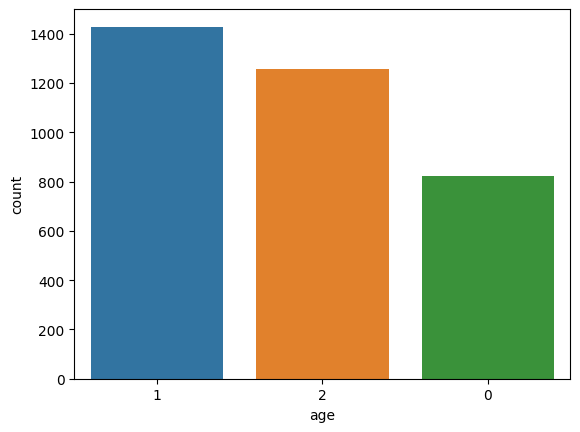

In [504]:

# usunięcie kolumny 'death_year'
df.drop('director_deathYear', axis=1, inplace=True)

# zastąpienie wartości '-' w kolumnie 'director_birthYear' wartością NaN
df['director_birthYear'] = df['director_birthYear'].replace('-', np.nan)
# zamiana typu kolumny 'director_birthYear' na int
df['director_birthYear'] = pd.to_numeric(df['director_birthYear'], errors='coerce')
# utworzenie kolumny 'age' na podstawie kolumn 'production_year' i 'director_birthYear', jesli nie ma birthYear to age = 0
df['age'] = df['production_year'] - df['director_birthYear']
# podział age na 3 przedziały wiekowe
df['age'] = pd.cut(df['age'], bins=[0, 40, 55, 200], labels=['young', 'middle-aged', 'old'])
# encoding kolumny age na int
df['age'] = df['age'].map({'young': 0, 'middle-aged': 1, 'old': 2})
# zamiana wartości NaN na losowe wartości z przedziału (0, 2)
df['age'] = df['age'].fillna(np.random.randint(0, 3))
# usunięcie kolumny 'director_birthYear'
df.drop('director_birthYear', axis=1, inplace=True)

df.head()

countplot = sns.countplot(data=df, x='age', order = df['age'].value_counts().index)

### Niepoprawne wartości - podejrzane duplikaty - NIE WIEM CO CHCECIE Z TYM ZROBIĆ CZY RĘCZNIE POWPISYWAĆ WARTOŚCI SZUKAJĄC TYCH FILMÓW CZY JAKOŚ LOSOWO UZUPEŁNIĆ ALE JAK MACIE POMYSŁ TO FEEL FREE ŻEBY ZROBIĆ, do uzupełnienia byłyby budżety, rok i miesiac produkcji głównie

In [505]:
#Sprawdzenie filmów o tym samym tytule
print(df['movie_title'].value_counts().head(20))

df[df['movie_title'] == 'Breakthrough'].head()

#trzeba coś z tym zrobić

Brothers               3
Halloween              3
Hercules               3
The Visit              3
Weekend                3
Redemption             3
The Addams Family      2
Malevolence            2
Life of the Party      2
An Ideal Husband       2
Conan the Barbarian    2
Breakthrough           2
West Side Story        2
The Jungle Book        2
The Omen               2
The Promise            2
Upside Down            2
Babylon                2
The Great Wall         2
Cinderella             2
Name: movie_title, dtype: int64


,movie_title,genres,runtime_minutes,director_name,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year,month_sin,month_cos,number_of_professions,age
2142,Breakthrough,"Biography,Drama",116.0,1324,6.2,10212.0,4.079181,14000000,40713082,49231674,2019,0.866025,-0.5,3,2
2282,Breakthrough,"Drama,War",90.0,347,5.0,227.0,1.863877,14000000,40713082,49231674,2019,0.866025,-0.5,3,2


#### Tytuły - z uwzględnieniem filmów będących częścią jednej serii ? 

In [506]:
#nie wiem wsm czy jest sens to robić, jak macie pomysł to zróbcie, jak nie to imo można wywalić ta kolumne 

#usuniecie kolumny z tytułem
df.drop('movie_title', axis=1, inplace=True)

### Skalowanie - logarytmiczne

array([[<Axes: title={'center': 'runtime_minutes'}>,
        <Axes: title={'center': 'director_name'}>,
        <Axes: title={'center': 'movie_averageRating'}>],
       [<Axes: title={'center': 'movie_numerOfVotes'}>,
        <Axes: title={'center': 'approval_Index'}>,
        <Axes: title={'center': 'Production budget $'}>],
       [<Axes: title={'center': 'Domestic gross $'}>,
        <Axes: title={'center': 'Worldwide gross $'}>,
        <Axes: title={'center': 'production_year'}>],
       [<Axes: title={'center': 'month_sin'}>,
        <Axes: title={'center': 'month_cos'}>,
        <Axes: title={'center': 'number_of_professions'}>]], dtype=object)

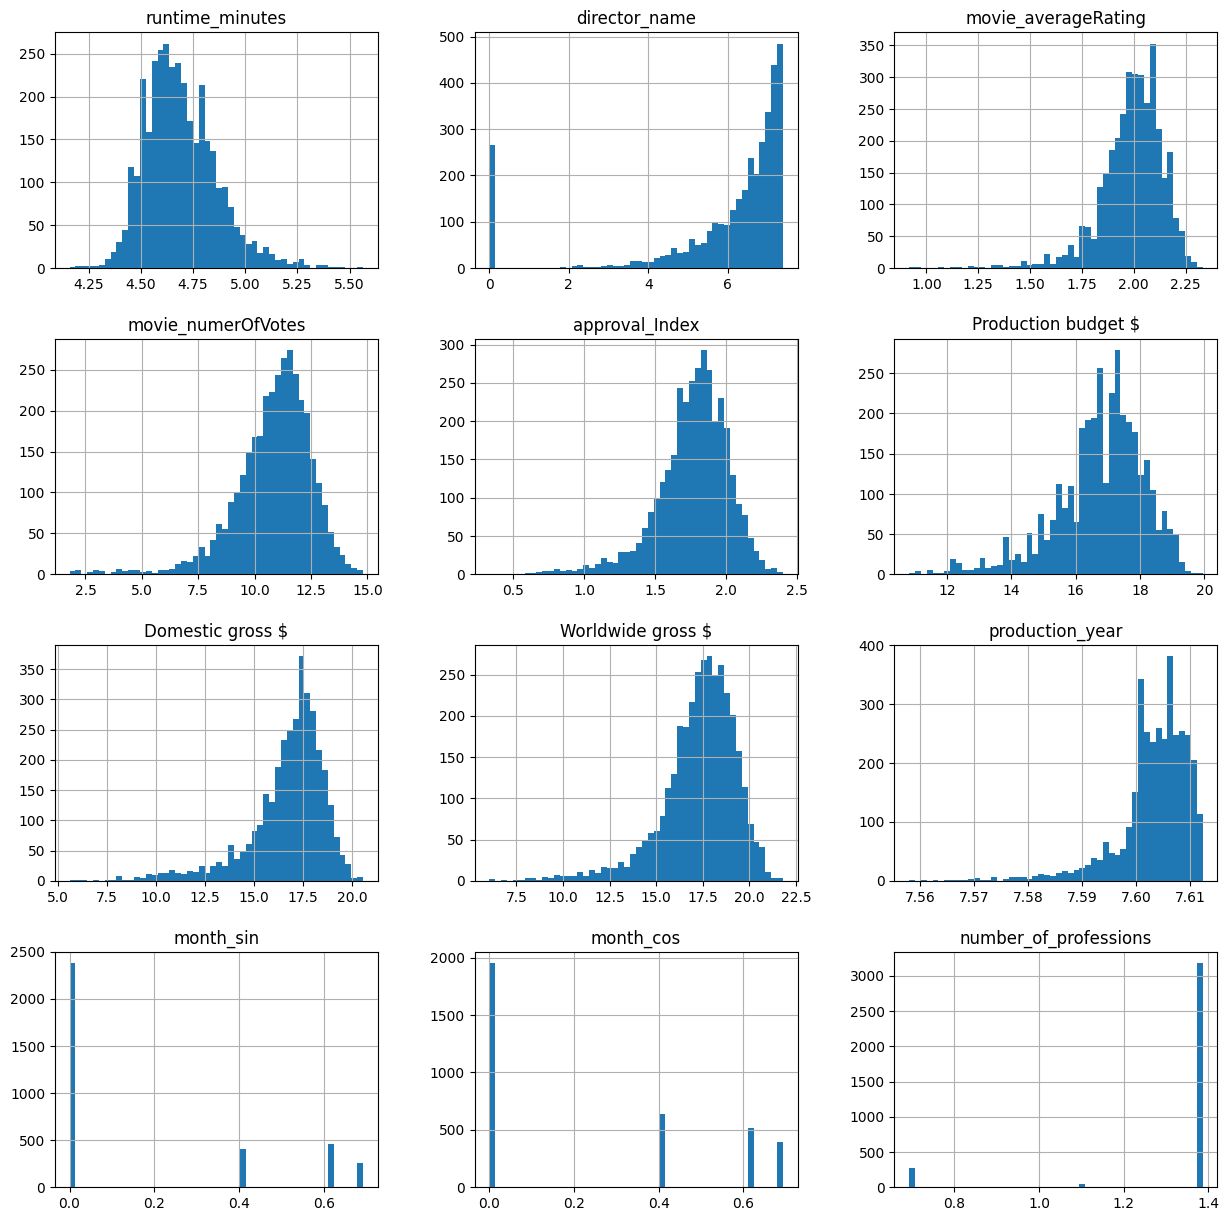

In [507]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
# Zastąp wartości ujemne i zero małą dodatnią wartością
df[numerical_cols] = df[numerical_cols].applymap(lambda x: x if x > 0 else 1e-10)

# Przekształcenie logarytmiczne
df_log = np.log1p(df[numerical_cols])

# Rysowanie histogramu
df_log.hist(bins=50, figsize=(15, 15))
#testy modeli bedzie mozna zrobic na obu wersjach

#### Gatunki one hot encoding

In [508]:
#### Gatunki - one hot encoding
# One-hot encoding gatunków
genres_one_hot = df['genres'].str.get_dummies(sep=',')
df = pd.concat([df, genres_one_hot], axis=1)

#usuwanie niepotrzebnych kolumn
df.drop('genres', axis=1, inplace=True)
df.head()

,runtime_minutes,director_name,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $,production_year,month_sin,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,116.0,1279.0,6.3,5077.0,3.823171,19000000,1353824,1353824,1996,1.000000e-10,...,1,0,0,0,0,0,0,0,0,0
1,114.0,753.0,6.2,22262.0,4.434679,30000000,50081992,140081992,1993,8.660254e-01,...,0,0,1,0,1,0,0,0,0,0
2,124.0,180.0,7.1,145614.0,6.078636,50000000,75624550,118729073,2011,1.000000e-10,...,0,0,0,0,0,0,0,0,0,0
3,125.0,903.0,7.0,110757.0,5.850243,14000000,46800000,185400000,1977,1.000000e-10,...,0,0,0,0,0,0,0,1,0,0
4,98.0,1427.0,6.1,41748.0,4.643223,9500000,57176582,59675307,2000,5.000000e-01,...,0,0,0,0,0,0,0,0,0,0


### Standaryzacja kolumn - możecie dodać jakieś bardziej mądre - WSM JEDNAK Z WYKRESÓW ŁOKCIOWYCH TO JA NIE WIEM CZY W OGÓLE SIE POWINNO TE DANE STANDARYZOWAĆ DLA KLASTERINGU

In [509]:
# df_log - logarytmiczne przekształcenie już zrobione
# df - oryginalne dane

# Standaryzacja
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_log_scaled = scaler.fit_transform(df_log)
df_log_scaled = pd.DataFrame(df_log_scaled, columns=df_log.columns)

# Normalizacja
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_log_normalized = scaler.fit_transform(df_log[numerical_cols])
df_log_normalized = pd.DataFrame(df_log_normalized, columns=numerical_cols)

# Standaryzacja + Normalizacja bez logarytmicznego przekształcenia (uzywajac df)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_cols])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_cols)

scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_scaled[numerical_cols])
df_normalized_scaled = pd.DataFrame(df_normalized, columns=numerical_cols)

# Sprawdzenie rozkładu
#df_log_scaled.hist(bins=50, figsize=(15, 15))
#df_log_normalized.hist(bins=50, figsize=(15, 15))
#df_normalized_scaled.hist(bins=50, figsize=(15, 15))

#### Jakoś określić importance kolumn by wypadało i przetestować różne warianty

## Wstępne modelowanie  - to dla was w większości chłopaki
-metoda łokcia  
-bylo to takie fajne drzewiaste i sie odcinalo na jakims poziomie
-tsne  
-kmeans  
-moze jeszcze inne jakies modele  

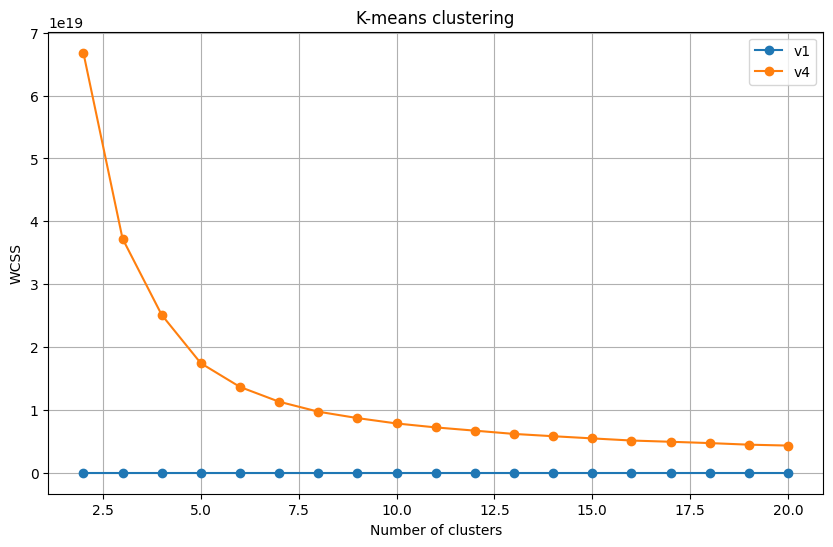

In [519]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#może warto sprawdzić dla tych wersji, idk
v1= df_log_scaled
v2= df_log_normalized
v3= df_normalized_scaled
v4= df

#jednak zamiast tych wersji można spróbować innych z różnymi kolumnami, np. bez gatunków, bez reżysera, bez roku produkcji, bez budżetów itp.

#metoda łokcia
from sklearn.cluster import KMeans
from sklearn import metrics

def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    return wcss

wcss_v1 = calculate_wcss(v1)
#wcss_v2 = calculate_wcss(v2) - na wykresie ten sam wynik co v1
#wcss_v3 = calculate_wcss(v3) - na wykresie ten sam wynik co v1
wcss_v4 = calculate_wcss(v4)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), wcss_v1, marker='o', label='v1')
#plt.plot(range(2, 21), wcss_v2, marker='o', label='v2')
#plt.plot(range(2, 21), wcss_v3, marker='o', label='v3')
plt.plot(range(2, 21), wcss_v4, marker='o', label='v4')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.legend()
plt.grid()
plt.show()


z wykresu powyżej wnioskuję że chyba jednak się nie powinno standaryzować, a optymalna liczba klastrów dla wariantu v4 się wydaje być koło 5, może 8

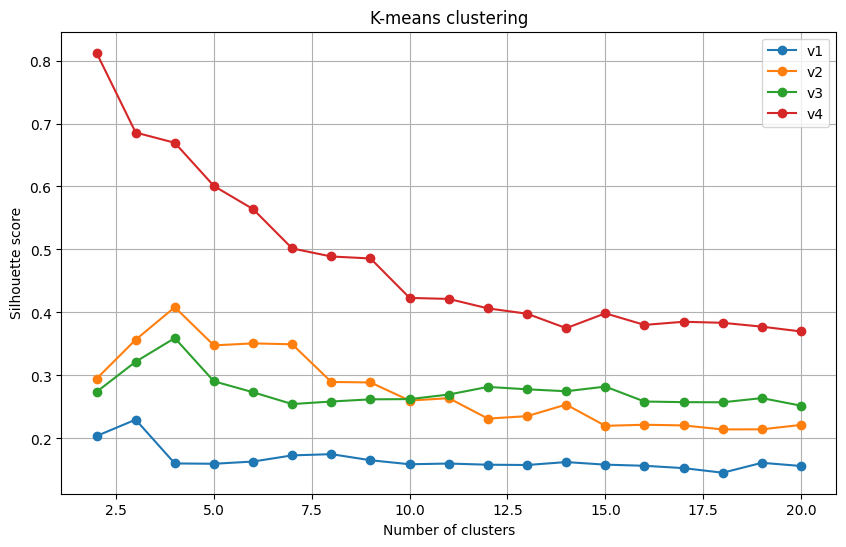

In [515]:
#silhouette score
from sklearn.metrics import silhouette_score

def calculate_silhouette_score(data):
    silhouette_scores = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    return silhouette_scores

silhouette_scores_v1 = calculate_silhouette_score(v1)
silhouette_scores_v2 = calculate_silhouette_score(v2)
silhouette_scores_v3 = calculate_silhouette_score(v3)
silhouette_scores_v4 = calculate_silhouette_score(v4)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores_v1, marker='o', label='v1')
plt.plot(range(2, 21), silhouette_scores_v2, marker='o', label='v2')
plt.plot(range(2, 21), silhouette_scores_v3, marker='o', label='v3')
plt.plot(range(2, 21), silhouette_scores_v4, marker='o', label='v4')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('K-means clustering')
plt.legend()
plt.grid()
plt.show()

znowu, v4 wygląda najbardziej sensownie ale nie wiem dokładnie jak to działa

In [ ]:
# co robi silhoutte score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

# silhouette score - miara jakości podziału
# wartości z przedziału [-1, 1]
# im bliżej 1 tym lepiej
# 0 oznacza przypadek, gdy klastry się nakładają
# wartości ujemne oznaczają, że obserwacje zostały przypisane do złego klastra

niżej się zaczełam bawić w jakieś rzeczy ale już chyba nie ruszam

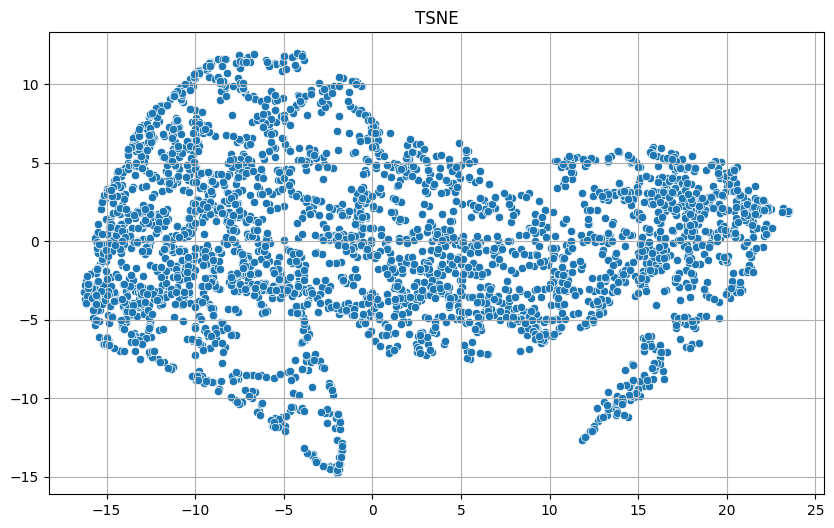

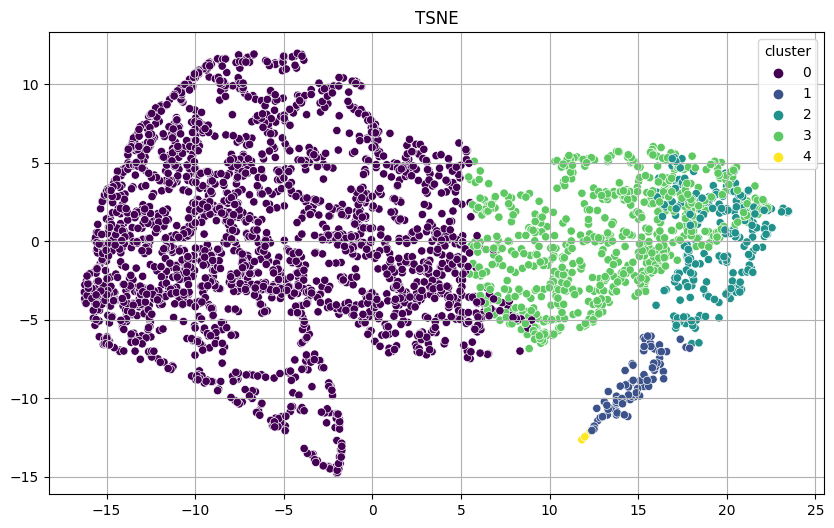

In [529]:
#tsne na wariancie v4
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=4324)
tsne_results = tsne.fit_transform(v4)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])
plt.title('TSNE')
plt.grid()
plt.show()

#scatter plot na 5 klastrów
kmeans = KMeans(n_clusters=5, random_state=4324)
kmeans.fit(v4)
v4['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=v4['cluster'], palette='viridis')
plt.title('TSNE')
plt.grid()
plt.show()
